# Spatial deconvolution without reference scRNA-seq

This is a tutorial on an example real Spatial Transcriptomics (ST) data (CID44971_TNBC) from Wu et al., 2021. Raw tutorial could be found in https://starfysh.readthedocs.io/en/latest/notebooks/Starfysh_tutorial_real.html


Starfysh performs cell-type deconvolution followed by various downstream analyses to discover spatial interactions in tumor microenvironment. Specifically, Starfysh looks for anchor spots (presumably with the highest compositions of one given cell type) informed by user-provided gene signatures ([see example](https://drive.google.com/file/d/1AXWQy_mwzFEKNjAdrJjXuegB3onxJoOM/view?usp=share_link)) as priors to guide the deconvolution inference, which further enables downstream analyses such as sample integration, spatial hub characterization, cell-cell interactions, etc. This tutorial focuses on the deconvolution task. Overall, Starfysh provides the following options:

At omicverse, we have made the following improvements:
- Easier visualization, you can use omicverse unified visualization for scientific mapping
- Reduce installation dependency errors, we optimized the automatic selection of different packages, you don't need to install too many extra packages and cause conflicts.

**Base feature**:

- Spot-level deconvolution with expected cell types and corresponding annotated signature gene sets (default)


He, S., Jin, Y., Nazaret, A. et al.
Starfysh integrates spatial transcriptomic and histologic data to reveal heterogeneous tumor–immune hubs.
Nat Biotechnol (2024).
https://doi.org/10.1038/s41587-024-02173-8

In [1]:
import cv2
import scanpy as sc
import omicverse as ov
ov.style(font_path='Arial')

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting GPU devices…
✅ NVIDIA CUDA GPUs detected: 1
    • [CUDA 0] NVIDIA H100 80GB HBM3
      Memory: 79.1 GB | Compute: 9.0

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.9rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.



## Step 1: Prepare spatial transcriptomics (1 min)

Purpose: load 10x Visium (Space Ranger outputs) or similar to obtain a coordinate-aware spatial `AnnData` (`adata_sp`).

- Inputs: Visium count matrix and spatial coordinates (from the `spatial` folder)
- Outputs: `AnnData` object (`adata_sp`) with spot coordinates and counts
- Key points:
  - Ensure maximal gene overlap with the scRNA-seq reference; map gene IDs if necessary.
  - For multiple samples, keep batch labels explicit to support merging and visualization.



In [2]:
adata_sp = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_sp.obs['sample'] = list(adata_sp.uns['spatial'].keys())[0]
adata_sp.var_names_make_unique()

reading /scratch/users/steorra/analysis/omic_test/data/V1_Human_Lymph_Node/filtered_feature_bc_matrix.h5
 (0:00:00)


## Step 2: Prepare the gene sig marker

gene_sig means the dataframe stored the marker gene in each columns. If you don't have it, you can calculated it using `ov.space.calculate_gene_signature`

In [3]:
# Load your scRNA-seq reference
# Example: Human lymph node reference
adata_sc = ov.datasets.sc_ref_Lymph_Node()
gene_sig=ov.space.calculate_gene_signature(
    adata_sc,
    clustertype='Subset',      # cell type name
    rank=True,
    key='rank_genes_groups',
    foldchange=2,
    topgenenumber=20    
)
gene_sig.head()

🧬 Loading SC reference data for Lymph Node
🔍 Downloading data to ./data/sc_ref_Lymph_Node.h5ad
⚠️ File ./data/sc_ref_Lymph_Node.h5ad already exists
 Loading data from ./data/sc_ref_Lymph_Node.h5ad
✅ Successfully loaded: 73260 cells × 10237 genes
...get cell type marker
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:00)


B_Cycling B_GC_DZ  B_GC_LZ B_GC_prePB     B_IFN B_activated     B_mem  \
0     HMGN2   CD79B     CD22        BIK  HLA-DPA1    HLA-DPA1  HLA-DPA1   
1       DEK   TCEA1  PRPSAP2    PRPSAP2     ISG15       HVCN1      CD52   
2     HMGN1   GAPDH    HMGN1     VPREB3     STAT1        CD74    SMIM14   
3     GAPDH   SUGCT    GAPDH      HMCES      CD74       TCL1A      CD74   
4     HMGB1     EZR     CD74      MEF2B     IFIT3    HLA-DPB1    VPREB3   

    B_naive B_plasma   B_preGC  ... T_CD4+_TfH T_CD4+_TfH_GC T_CD4+_naive  \
0  HLA-DPA1   SDF2L1  HLA-DPA1  ...       TRAC          TCF7       RPS15A   
1     HVCN1     SSR3      CD72  ...       CD69          SRGN        NOSIP   
2     CD79B     PPIB      NME2  ...       SRGN          PASK         TCF7   
3      CD72   SEC61G      CD74  ...       CD3E         ITM2A        RPS14   
4      CD74  HERPUD1  HSP90AB1  ...     SLC2A3          CD3E         LEF1   

  T_CD8+_CD161+ T_CD8+_cytotoxic T_CD8+_naive T_TIM3+        T_TfR  T_Treg  \
0         ZFP36             CD3E        NOSIP  TMSB4X          CD4    TRAC   
1          SRGN             CST7         TCF7     LCK         SRGN    SRGN   
2          RGCC             GZMK         RGCC    SRGN         CD3E    RGCC   
3          CD8A             NKG7       DNAJB1    CD3E        ZAP70  DNAJB1   
4          CCL5             CTSW         LEF1    CD27  TCRA_VDJsum   FOXP3   

      VSMC  
0    TAGLN  
1   LGALS3  
2     CST3  
3  LAPTM4A  
4   IGFBP5  

[5 rows x 34 columns]

In [7]:
gene_sig.to_csv('data/gene_sig_Lymph_Node.csv')

In [3]:
gene_sig=ov.pd.read_csv('data/gene_sig_Lymph_Node.csv',index_col=0)
gene_sig.head()

B_Cycling B_GC_DZ  B_GC_LZ B_GC_prePB     B_IFN B_activated     B_mem  \
0     HMGN2   CD79B     CD22        BIK  HLA-DPA1    HLA-DPA1  HLA-DPA1   
1       DEK   TCEA1  PRPSAP2    PRPSAP2     ISG15       HVCN1      CD52   
2     HMGN1   GAPDH    HMGN1     VPREB3     STAT1        CD74    SMIM14   
3     GAPDH   SUGCT    GAPDH      HMCES      CD74       TCL1A      CD74   
4     HMGB1     EZR     CD74      MEF2B     IFIT3    HLA-DPB1    VPREB3   

    B_naive B_plasma   B_preGC  ... T_CD4+_TfH T_CD4+_TfH_GC T_CD4+_naive  \
0  HLA-DPA1   SDF2L1  HLA-DPA1  ...       TRAC          TCF7       RPS15A   
1     HVCN1     SSR3      CD72  ...       CD69          SRGN        NOSIP   
2     CD79B     PPIB      NME2  ...       SRGN          PASK         TCF7   
3      CD72   SEC61G      CD74  ...       CD3E         ITM2A        RPS14   
4      CD74  HERPUD1  HSP90AB1  ...     SLC2A3          CD3E         LEF1   

  T_CD8+_CD161+ T_CD8+_cytotoxic T_CD8+_naive T_TIM3+        T_TfR  T_Treg  \
0         ZFP36             CD3E        NOSIP  TMSB4X          CD4    TRAC   
1          SRGN             CST7         TCF7     LCK         SRGN    SRGN   
2          RGCC             GZMK         RGCC    SRGN         CD3E    RGCC   
3          CD8A             NKG7       DNAJB1    CD3E        ZAP70  DNAJB1   
4          CCL5             CTSW         LEF1    CD27  TCRA_VDJsum   FOXP3   

      VSMC  
0    TAGLN  
1   LGALS3  
2     CST3  
3  LAPTM4A  
4   IGFBP5  

[5 rows x 34 columns]

## Step 3: Deconvolution with starfysh

We perform n_repeat random restarts and select the best model with lowest loss for parameter c (inferred cell-type proportions):

Starfysh is integrated into the `omicverse.space.Deconvolution` class. Simply set `method='starfysh'`.

### Key Parameters

- `n_repeats`: Number of restart to run Starfysh.
- `epochs`: number of iterations
- `device`: the trainning device

In [4]:
# Initialize the Deconvolution object
decov_obj = ov.space.Deconvolution(
    adata_sp=adata_sp
)

In [5]:
decov_obj.preprocess_sp(
    mode='pearsonr',n_svgs=3000,target_sum=1e4,
    subset_genes=False,
)

🔍 [2026-01-11 23:07:13] Running preprocessing in 'cpu' mode...
Begin robust gene identification
    After filtration, 25187/36601 genes are kept.
    Among 25187 genes, 22411 genes are robust.
✅ Robust gene identification completed successfully.
Begin size normalization: shiftlog and HVGs selection pearson

🔍 Count Normalization:
   Target sum: 10000.0
   Exclude highly expressed: True
   Max fraction threshold: 0.2
   ⚠️ Excluding 1 highly-expressed genes from normalization computation
   Excluded genes: ['IGKC']

✅ Count Normalization Completed Successfully!
   ✓ Processed: 4,035 cells × 22,411 genes
   ✓ Runtime: 0.47s

🔍 Highly Variable Genes Selection (Experimental):
   Method: pearson_residuals
   Target genes: 3,000
   Theta (overdispersion): 100

✅ Experimental HVG Selection Completed Successfully!
   ✓ Selected: 3,000 highly variable genes out of 22,411 total (13.4%)
   ✓ Results added to AnnData object:
     • 'highly_variable': Boolean vector (adata.var)
     • 'highly_varia

In [7]:
%time
# Run FlashDeconv deconvolution
decov_obj.deconvolution(
    method='starfysh',
    gene_sig=gene_sig,  
    starfysh_kwargs={
        'n_repeats':3,
        'epochs':200,
        'patience':50,
        'device':None,
        'batch_size':32,
        'alpha_mul':50,
        'lr':1e-4,
        'poe':False,
        'verbose':True,
        'n_anchors':60,
        'window_size':3,
    }
)

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 7.87 μs


[2026-01-11 23:10:37] Subsetting highly variable & signature genes ...
[2026-01-11 23:10:38] Smoothing library size by taking averaging with neighbor spots...
[2026-01-11 23:10:40] Retrieving & normalizing signature gene expressions...
[2026-01-11 23:11:04] Identifying anchor spots (highly expression of specific cell-type signatures)...
[2026-01-11 23:11:06] Computing intrinsic dimension to estimate k...


30 components are retained using conditional_number=40.00


[2026-01-11 23:11:09] Estimating lower bound of # archetype as 8...
[2026-01-11 23:13:12] 0.9213 variance explained by raw archetypes.
Merging raw archetypes within 100 NNs to get major archetypes
[2026-01-11 23:13:13] Finding 100 nearest neighbors for each archetype...
[2026-01-11 23:13:13] Finding 30 top marker genes for each archetype...
... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
[2026-01-11 23:13:23] Insufficient candidates to find 3 distant archetypes
Set n=0
[2026-01-11 23:13:23] Finding 30 top marker genes for each archetype...
... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
[2026-01-11 23:13:56] Recalculating anchor spots (highly expression of specific cell-type signatures)...
[2026-01-11 23:13:57] Running Starfysh with 3 restarts, choose the model with best parameters...
Training Epochs:   5%|▌         | 10/200 [00:14<04:37,  1.46s/it]

Epoch[10/200], train_loss: 1964.5555, train_reconst: 1717.3358, train_u: 17.7731,train_z: 12.2491,train_c: 216.1686,train_l: 1.0289


Training Epochs:  10%|█         | 20/200 [00:29<04:17,  1.43s/it]

Epoch[20/200], train_loss: 1836.5867, train_reconst: 1631.5397, train_u: 17.3562,train_z: 8.2599,train_c: 177.4633,train_l: 1.9675


Training Epochs:  15%|█▌        | 30/200 [00:43<04:05,  1.44s/it]

Epoch[30/200], train_loss: 1803.6228, train_reconst: 1611.8570, train_u: 17.0200,train_z: 6.8935,train_c: 165.4288,train_l: 2.4234


Training Epochs:  20%|██        | 40/200 [00:57<03:48,  1.43s/it]

Epoch[40/200], train_loss: 1784.1136, train_reconst: 1599.9807, train_u: 16.7433,train_z: 6.1974,train_c: 158.4979,train_l: 2.6943


Training Epochs:  25%|██▌       | 50/200 [01:12<03:34,  1.43s/it]

Epoch[50/200], train_loss: 1771.6689, train_reconst: 1591.6377, train_u: 16.5159,train_z: 5.8556,train_c: 154.8143,train_l: 2.8453


Training Epochs:  30%|███       | 60/200 [01:26<03:19,  1.43s/it]

Epoch[60/200], train_loss: 1761.9189, train_reconst: 1585.5430, train_u: 16.3333,train_z: 5.7242,train_c: 151.3896,train_l: 2.9288


Training Epochs:  35%|███▌      | 70/200 [01:40<03:05,  1.43s/it]

Epoch[70/200], train_loss: 1755.7707, train_reconst: 1580.6499, train_u: 16.1848,train_z: 5.6212,train_c: 150.3357,train_l: 2.9791


Training Epochs:  40%|████      | 80/200 [01:55<02:51,  1.43s/it]

Epoch[80/200], train_loss: 1748.3032, train_reconst: 1575.9084, train_u: 16.0641,train_z: 5.6020,train_c: 147.7620,train_l: 2.9667


Training Epochs:  45%|████▌     | 90/200 [02:09<02:36,  1.42s/it]

Epoch[90/200], train_loss: 1745.4689, train_reconst: 1573.8276, train_u: 15.9672,train_z: 5.5890,train_c: 147.1002,train_l: 2.9849


Training Epochs:  50%|█████     | 100/200 [02:23<02:23,  1.43s/it]

Epoch[100/200], train_loss: 1741.4059, train_reconst: 1571.2467, train_u: 15.8885,train_z: 5.5138,train_c: 145.7818,train_l: 2.9751


Training Epochs:  55%|█████▌    | 110/200 [02:37<02:08,  1.43s/it]

Epoch[110/200], train_loss: 1739.2005, train_reconst: 1569.5755, train_u: 15.8249,train_z: 5.5090,train_c: 145.3119,train_l: 2.9792


Training Epochs:  60%|██████    | 120/200 [02:52<01:54,  1.43s/it]

Epoch[120/200], train_loss: 1737.3613, train_reconst: 1568.0982, train_u: 15.7730,train_z: 5.5225,train_c: 144.9962,train_l: 2.9714


Training Epochs:  65%|██████▌   | 130/200 [03:06<01:39,  1.42s/it]

Epoch[130/200], train_loss: 1735.5456, train_reconst: 1567.2170, train_u: 15.7308,train_z: 5.5234,train_c: 144.1060,train_l: 2.9684


Training Epochs:  70%|███████   | 140/200 [03:20<01:25,  1.42s/it]

Epoch[140/200], train_loss: 1733.8153, train_reconst: 1565.6691, train_u: 15.6964,train_z: 5.5186,train_c: 143.9690,train_l: 2.9622


Training Epochs:  75%|███████▌  | 150/200 [03:34<01:11,  1.42s/it]

Epoch[150/200], train_loss: 1734.0409, train_reconst: 1565.6646, train_u: 15.6686,train_z: 5.5101,train_c: 144.2291,train_l: 2.9684


Training Epochs:  80%|████████  | 160/200 [03:49<00:56,  1.42s/it]

Epoch[160/200], train_loss: 1733.5203, train_reconst: 1564.8707, train_u: 15.6460,train_z: 5.5183,train_c: 144.5110,train_l: 2.9744


Training Epochs:  85%|████████▌ | 170/200 [04:03<00:42,  1.43s/it]

Epoch[170/200], train_loss: 1731.6396, train_reconst: 1563.7964, train_u: 15.6274,train_z: 5.5189,train_c: 143.7256,train_l: 2.9713


Training Epochs:  90%|█████████ | 180/200 [04:17<00:28,  1.43s/it]

Epoch[180/200], train_loss: 1730.6814, train_reconst: 1563.4632, train_u: 15.6123,train_z: 5.4934,train_c: 143.1347,train_l: 2.9779


Training Epochs:  95%|█████████▌| 190/200 [04:32<00:14,  1.44s/it]

Epoch[190/200], train_loss: 1730.8846, train_reconst: 1563.2024, train_u: 15.6000,train_z: 5.5424,train_c: 143.5656,train_l: 2.9743



[2026-01-11 23:18:43] Saving the best-performance model...
[2026-01-11 23:18:43]  === Finished training === 



Epoch[200/200], train_loss: 1730.3862, train_reconst: 1563.3851, train_u: 15.5899,train_z: 5.4530,train_c: 142.9817,train_l: 2.9766


Training Epochs:   5%|▌         | 10/200 [00:14<04:30,  1.42s/it]

Epoch[10/200], train_loss: 1964.5555, train_reconst: 1717.3358, train_u: 17.7731,train_z: 12.2491,train_c: 216.1686,train_l: 1.0289


Training Epochs:  10%|█         | 20/200 [00:28<04:17,  1.43s/it]

Epoch[20/200], train_loss: 1836.5867, train_reconst: 1631.5397, train_u: 17.3562,train_z: 8.2599,train_c: 177.4633,train_l: 1.9675


Training Epochs:  15%|█▌        | 30/200 [00:42<04:03,  1.43s/it]

Epoch[30/200], train_loss: 1803.6228, train_reconst: 1611.8570, train_u: 17.0200,train_z: 6.8935,train_c: 165.4288,train_l: 2.4234


Training Epochs:  20%|██        | 40/200 [00:57<03:49,  1.43s/it]

Epoch[40/200], train_loss: 1784.1136, train_reconst: 1599.9807, train_u: 16.7433,train_z: 6.1974,train_c: 158.4979,train_l: 2.6943


Training Epochs:  25%|██▌       | 50/200 [01:11<03:33,  1.42s/it]

Epoch[50/200], train_loss: 1771.6689, train_reconst: 1591.6377, train_u: 16.5159,train_z: 5.8556,train_c: 154.8143,train_l: 2.8453


Training Epochs:  30%|███       | 60/200 [01:25<03:20,  1.43s/it]

Epoch[60/200], train_loss: 1761.9189, train_reconst: 1585.5430, train_u: 16.3333,train_z: 5.7242,train_c: 151.3896,train_l: 2.9288


Training Epochs:  35%|███▌      | 70/200 [01:40<03:06,  1.43s/it]

Epoch[70/200], train_loss: 1755.7707, train_reconst: 1580.6499, train_u: 16.1848,train_z: 5.6212,train_c: 150.3357,train_l: 2.9791


Training Epochs:  40%|████      | 80/200 [01:54<02:50,  1.42s/it]

Epoch[80/200], train_loss: 1748.3032, train_reconst: 1575.9084, train_u: 16.0641,train_z: 5.6020,train_c: 147.7620,train_l: 2.9667


Training Epochs:  45%|████▌     | 90/200 [02:08<02:36,  1.42s/it]

Epoch[90/200], train_loss: 1745.4689, train_reconst: 1573.8276, train_u: 15.9672,train_z: 5.5890,train_c: 147.1002,train_l: 2.9849


Training Epochs:  50%|█████     | 100/200 [02:22<02:22,  1.43s/it]

Epoch[100/200], train_loss: 1741.4059, train_reconst: 1571.2467, train_u: 15.8885,train_z: 5.5138,train_c: 145.7818,train_l: 2.9751


Training Epochs:  55%|█████▌    | 110/200 [02:37<02:08,  1.43s/it]

Epoch[110/200], train_loss: 1739.2005, train_reconst: 1569.5755, train_u: 15.8249,train_z: 5.5090,train_c: 145.3119,train_l: 2.9792


Training Epochs:  60%|██████    | 120/200 [02:51<01:54,  1.43s/it]

Epoch[120/200], train_loss: 1737.3613, train_reconst: 1568.0982, train_u: 15.7730,train_z: 5.5225,train_c: 144.9962,train_l: 2.9714


Training Epochs:  65%|██████▌   | 130/200 [03:05<01:40,  1.43s/it]

Epoch[130/200], train_loss: 1735.5456, train_reconst: 1567.2170, train_u: 15.7308,train_z: 5.5234,train_c: 144.1060,train_l: 2.9684


Training Epochs:  70%|███████   | 140/200 [03:20<01:25,  1.43s/it]

Epoch[140/200], train_loss: 1733.8153, train_reconst: 1565.6691, train_u: 15.6964,train_z: 5.5186,train_c: 143.9690,train_l: 2.9622


Training Epochs:  75%|███████▌  | 150/200 [03:34<01:11,  1.43s/it]

Epoch[150/200], train_loss: 1734.0409, train_reconst: 1565.6646, train_u: 15.6686,train_z: 5.5101,train_c: 144.2291,train_l: 2.9684


Training Epochs:  80%|████████  | 160/200 [03:48<00:57,  1.43s/it]

Epoch[160/200], train_loss: 1733.5203, train_reconst: 1564.8707, train_u: 15.6460,train_z: 5.5183,train_c: 144.5110,train_l: 2.9744


Training Epochs:  85%|████████▌ | 170/200 [04:02<00:42,  1.43s/it]

Epoch[170/200], train_loss: 1731.6396, train_reconst: 1563.7964, train_u: 15.6274,train_z: 5.5189,train_c: 143.7256,train_l: 2.9713


Training Epochs:  90%|█████████ | 180/200 [04:17<00:28,  1.44s/it]

Epoch[180/200], train_loss: 1730.6814, train_reconst: 1563.4632, train_u: 15.6123,train_z: 5.4934,train_c: 143.1347,train_l: 2.9779


Training Epochs:  95%|█████████▌| 190/200 [04:31<00:14,  1.44s/it]

Epoch[190/200], train_loss: 1730.8846, train_reconst: 1563.2024, train_u: 15.6000,train_z: 5.5424,train_c: 143.5656,train_l: 2.9743



[2026-01-11 23:23:29] Saving the best-performance model...
[2026-01-11 23:23:29]  === Finished training === 



Epoch[200/200], train_loss: 1730.3862, train_reconst: 1563.3851, train_u: 15.5899,train_z: 5.4530,train_c: 142.9817,train_l: 2.9766


Training Epochs:   5%|▌         | 10/200 [00:14<04:30,  1.43s/it]

Epoch[10/200], train_loss: 1964.5555, train_reconst: 1717.3358, train_u: 17.7731,train_z: 12.2491,train_c: 216.1686,train_l: 1.0289


Training Epochs:  10%|█         | 20/200 [00:28<04:17,  1.43s/it]

Epoch[20/200], train_loss: 1836.5867, train_reconst: 1631.5397, train_u: 17.3562,train_z: 8.2599,train_c: 177.4633,train_l: 1.9675


Training Epochs:  15%|█▌        | 30/200 [00:42<04:04,  1.44s/it]

Epoch[30/200], train_loss: 1803.6228, train_reconst: 1611.8570, train_u: 17.0200,train_z: 6.8935,train_c: 165.4288,train_l: 2.4234


Training Epochs:  20%|██        | 40/200 [00:56<03:41,  1.39s/it]

Epoch[40/200], train_loss: 1784.1136, train_reconst: 1599.9807, train_u: 16.7433,train_z: 6.1974,train_c: 158.4979,train_l: 2.6943


Training Epochs:  25%|██▌       | 50/200 [01:11<03:33,  1.43s/it]

Epoch[50/200], train_loss: 1771.6689, train_reconst: 1591.6377, train_u: 16.5159,train_z: 5.8556,train_c: 154.8143,train_l: 2.8453


Training Epochs:  30%|███       | 60/200 [01:25<03:20,  1.43s/it]

Epoch[60/200], train_loss: 1761.9189, train_reconst: 1585.5430, train_u: 16.3333,train_z: 5.7242,train_c: 151.3896,train_l: 2.9288


Training Epochs:  35%|███▌      | 70/200 [01:39<03:07,  1.44s/it]

Epoch[70/200], train_loss: 1755.7707, train_reconst: 1580.6499, train_u: 16.1848,train_z: 5.6212,train_c: 150.3357,train_l: 2.9791


Training Epochs:  40%|████      | 80/200 [01:54<02:51,  1.43s/it]

Epoch[80/200], train_loss: 1748.3032, train_reconst: 1575.9084, train_u: 16.0641,train_z: 5.6020,train_c: 147.7620,train_l: 2.9667


Training Epochs:  45%|████▌     | 90/200 [02:08<02:38,  1.44s/it]

Epoch[90/200], train_loss: 1745.4689, train_reconst: 1573.8276, train_u: 15.9672,train_z: 5.5890,train_c: 147.1002,train_l: 2.9849


Training Epochs:  50%|█████     | 100/200 [02:22<02:23,  1.43s/it]

Epoch[100/200], train_loss: 1741.4059, train_reconst: 1571.2467, train_u: 15.8885,train_z: 5.5138,train_c: 145.7818,train_l: 2.9751


Training Epochs:  55%|█████▌    | 110/200 [02:37<02:08,  1.43s/it]

Epoch[110/200], train_loss: 1739.2005, train_reconst: 1569.5755, train_u: 15.8249,train_z: 5.5090,train_c: 145.3119,train_l: 2.9792


Training Epochs:  60%|██████    | 120/200 [02:51<01:54,  1.44s/it]

Epoch[120/200], train_loss: 1737.3613, train_reconst: 1568.0982, train_u: 15.7730,train_z: 5.5225,train_c: 144.9962,train_l: 2.9714


Training Epochs:  65%|██████▌   | 130/200 [03:05<01:40,  1.43s/it]

Epoch[130/200], train_loss: 1735.5456, train_reconst: 1567.2170, train_u: 15.7308,train_z: 5.5234,train_c: 144.1060,train_l: 2.9684


Training Epochs:  70%|███████   | 140/200 [03:19<01:25,  1.43s/it]

Epoch[140/200], train_loss: 1733.8153, train_reconst: 1565.6691, train_u: 15.6964,train_z: 5.5186,train_c: 143.9690,train_l: 2.9622


Training Epochs:  75%|███████▌  | 150/200 [03:34<01:11,  1.43s/it]

Epoch[150/200], train_loss: 1734.0409, train_reconst: 1565.6646, train_u: 15.6686,train_z: 5.5101,train_c: 144.2291,train_l: 2.9684


Training Epochs:  80%|████████  | 160/200 [03:48<00:57,  1.43s/it]

Epoch[160/200], train_loss: 1733.5203, train_reconst: 1564.8707, train_u: 15.6460,train_z: 5.5183,train_c: 144.5110,train_l: 2.9744


Training Epochs:  85%|████████▌ | 170/200 [04:02<00:42,  1.43s/it]

Epoch[170/200], train_loss: 1731.6396, train_reconst: 1563.7964, train_u: 15.6274,train_z: 5.5189,train_c: 143.7256,train_l: 2.9713


Training Epochs:  90%|█████████ | 180/200 [04:17<00:28,  1.43s/it]

Epoch[180/200], train_loss: 1730.6814, train_reconst: 1563.4632, train_u: 15.6123,train_z: 5.4934,train_c: 143.1347,train_l: 2.9779


Training Epochs:  95%|█████████▌| 190/200 [04:31<00:14,  1.44s/it]

Epoch[190/200], train_loss: 1730.8846, train_reconst: 1563.2024, train_u: 15.6000,train_z: 5.5424,train_c: 143.5656,train_l: 2.9743



[2026-01-11 23:28:15] Saving the best-performance model...
[2026-01-11 23:28:15]  === Finished training === 



Epoch[200/200], train_loss: 1730.3862, train_reconst: 1563.3851, train_u: 15.5899,train_z: 5.4530,train_c: 142.9817,train_l: 2.9766
✓ starfysh is done
The starfysh result is saved in self.adata_cell2location
The starfysh model is saved in self.starfysh_model


## Step 4: Visualization (5–15 min)

We provide multiple views: single-target spatial heatmaps, multi-target overlays, and local pie charts. Start with global inspection, then zoom into biologically relevant regions for higher-resolution assessment.

### 4.1 Spatial value dotplot 


... storing 'feature_types' as categorical
... storing 'genome' as categorical


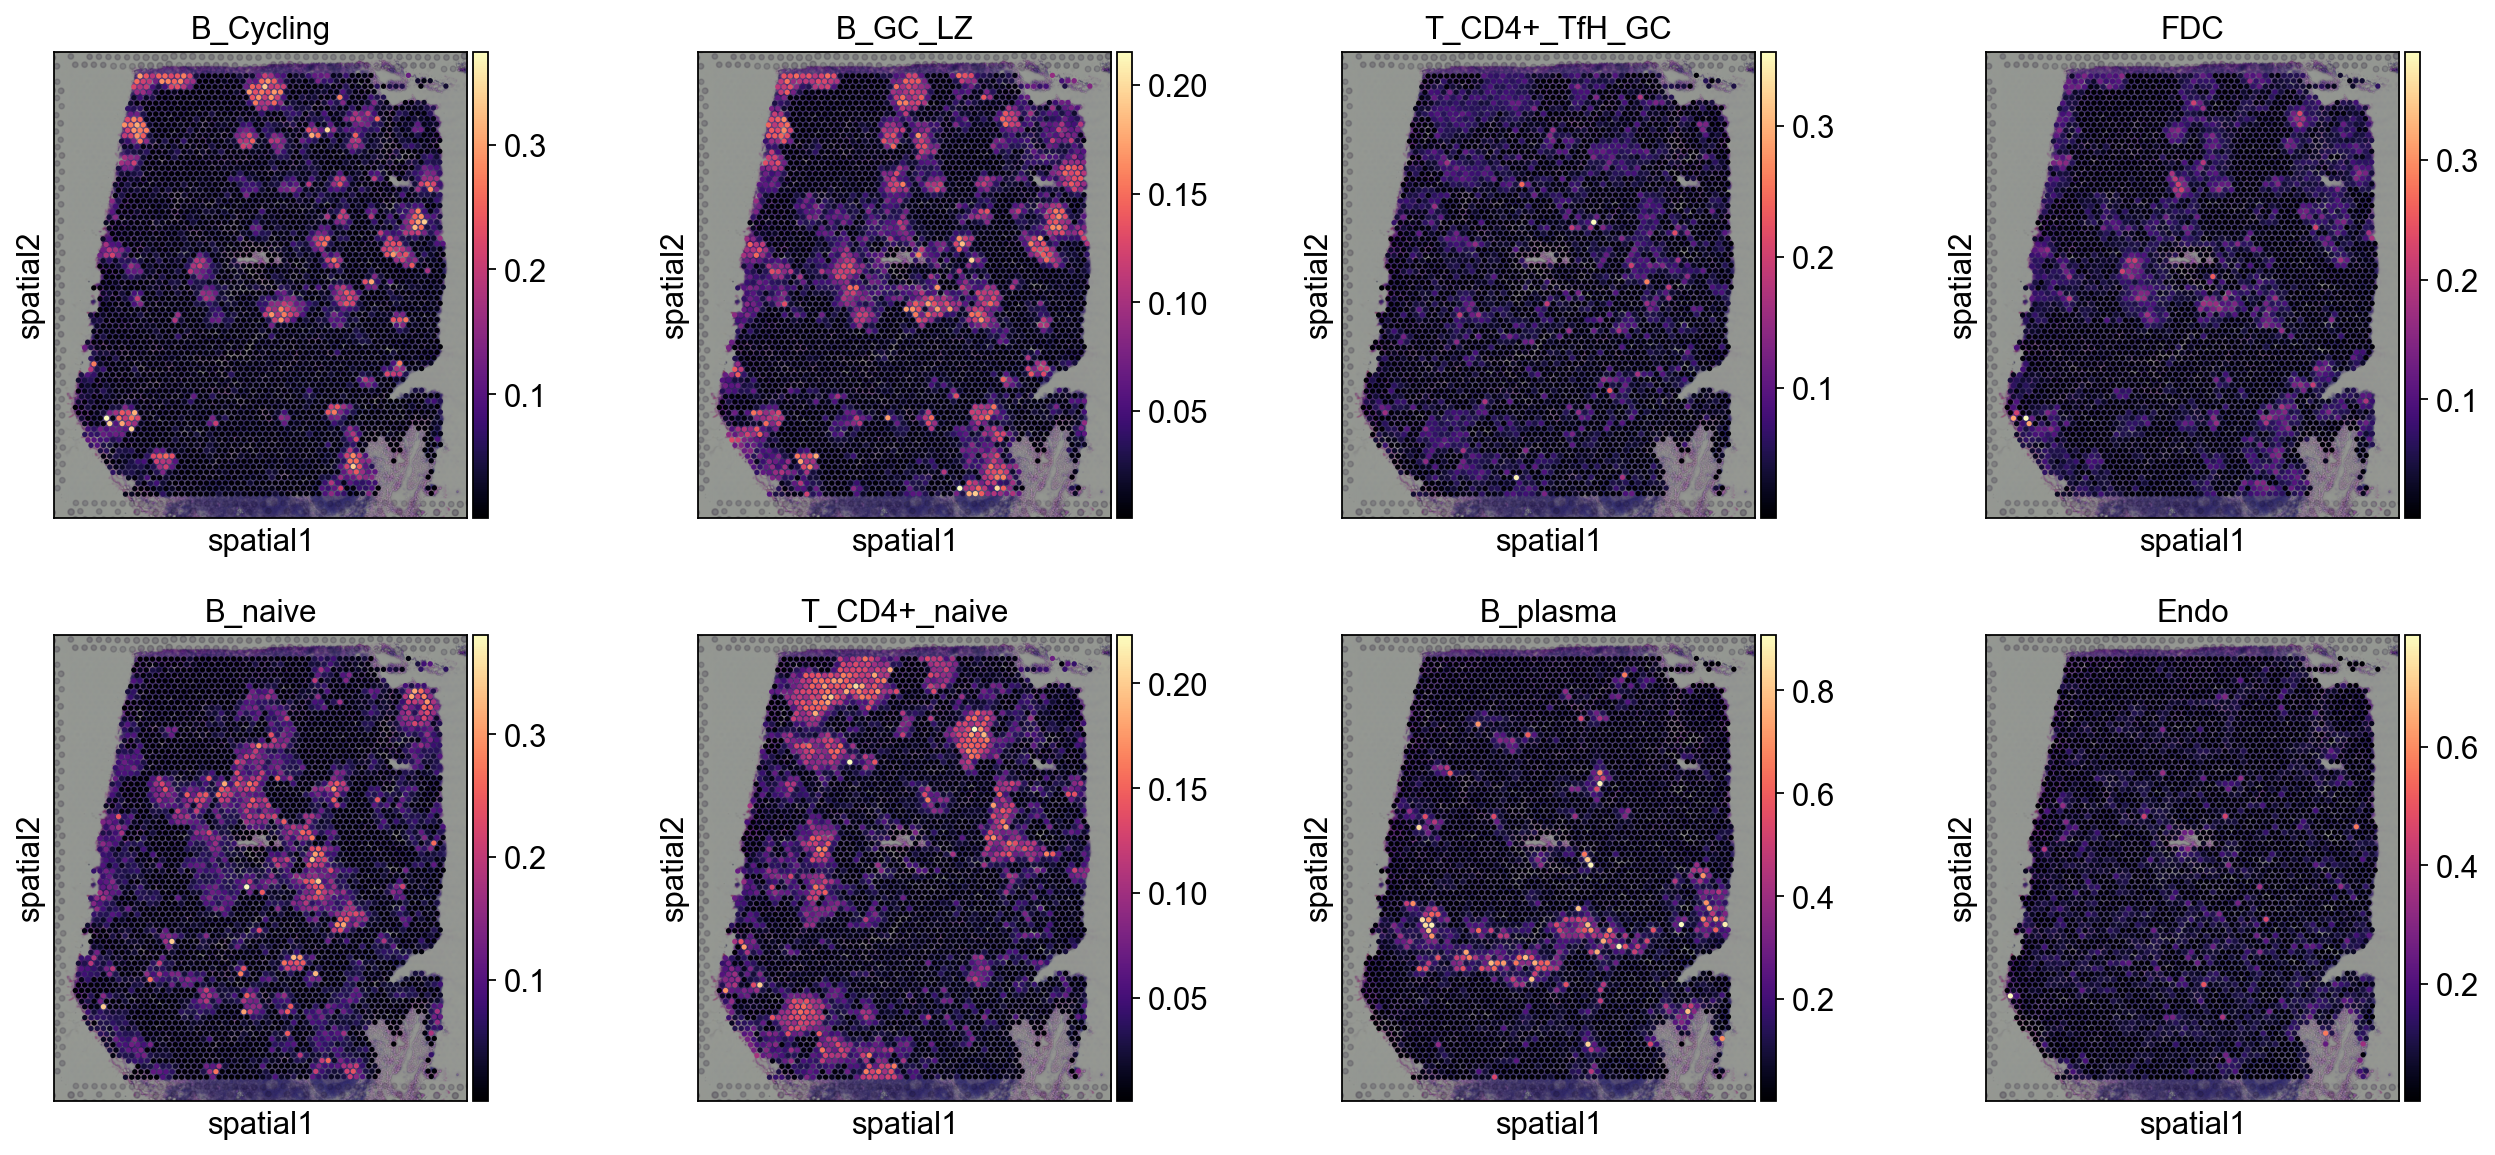

In [8]:
annotation_list=['B_Cycling', 'B_GC_LZ', 'T_CD4+_TfH_GC', 'FDC',
                'B_naive', 'T_CD4+_naive', 'B_plasma', 'Endo']
sc.pl.spatial(
    decov_obj.adata_cell2location, 
    cmap='magma',
    # show first 8 cell types
    color=annotation_list,
    ncols=4, size=1.3,
    img_key='hires',
    # limit color scale at 99.2% quantile of cell abundance
    #vmin=0, vmax='p99.2'
)

### 4.2 Multi-target overlay


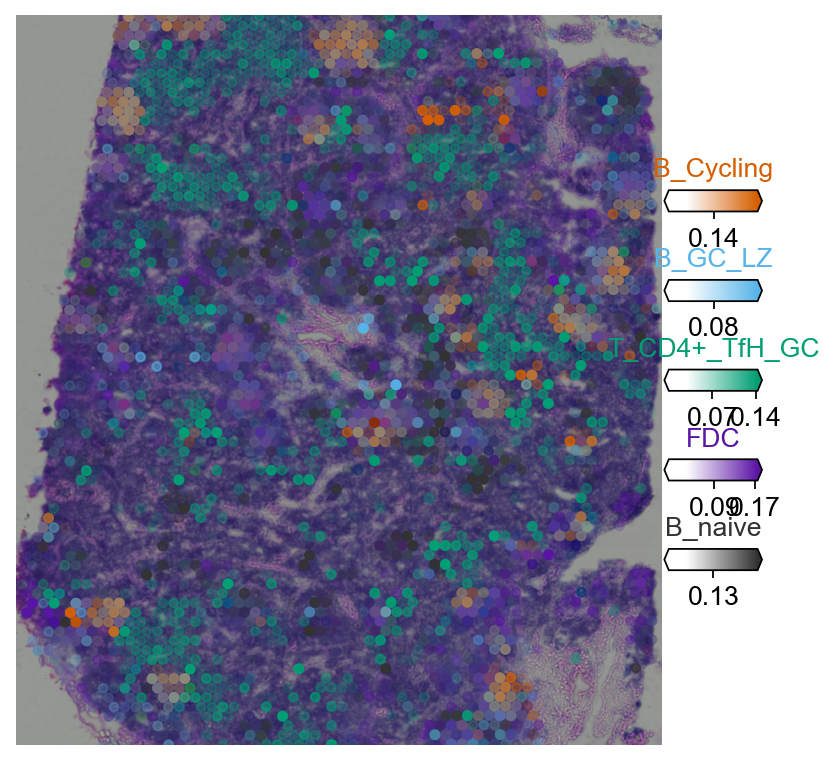

In [10]:
import matplotlib as mpl
clust_labels = annotation_list[:5]
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

with mpl.rc_context({'figure.figsize': (6, 6),'axes.grid': False}):
    fig = ov.pl.plot_spatial(
        adata=decov_obj.adata_cell2location,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=4,
        reorder_cmap = [#0,
            1,2,3,4,6], #['yellow', 'orange', 'blue', 'green', 'purple', 'grey', 'white'],
        colorbar_position='right',
        #palette=color_dict
    )
    

### 4.3 Pie plot

We recommend cropping a region of interest before plotting to avoid overly dense pie charts on whole slides.


In [11]:
adata_s = ov.space.crop_space_visium(
    decov_obj.adata_cell2location, 
    crop_loc=(0, 0),      
    crop_area=(500, 1000), 
    library_id=list(decov_obj.adata_cell2location.uns['spatial'].keys())[0] , 
    scale=1
)

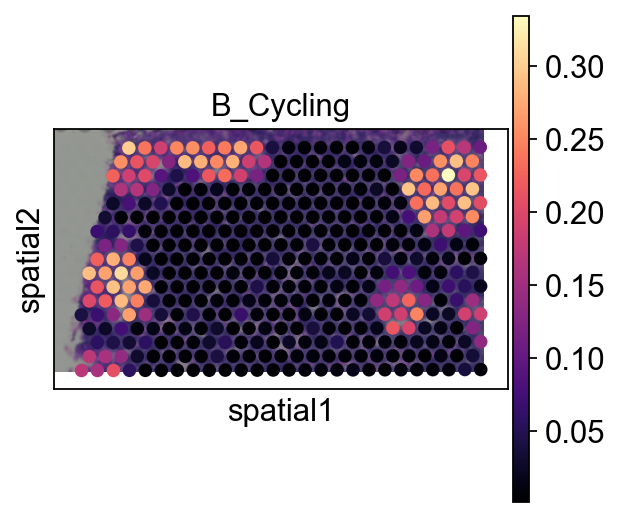

In [12]:
sc.pl.spatial(adata_s, cmap='magma',
                  # show first 8 cell types
                  color=annotation_list[0],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  #vmin=0, vmax='p99.2'
                 )

In [16]:
color_dict=dict(zip(annotation_list,
                   ov.pl.sc_color))


00%|██████████| 417/417 [00:01<00:00, 288.25it/s]

<Axes: xlabel='spatial1', ylabel='spatial2'>

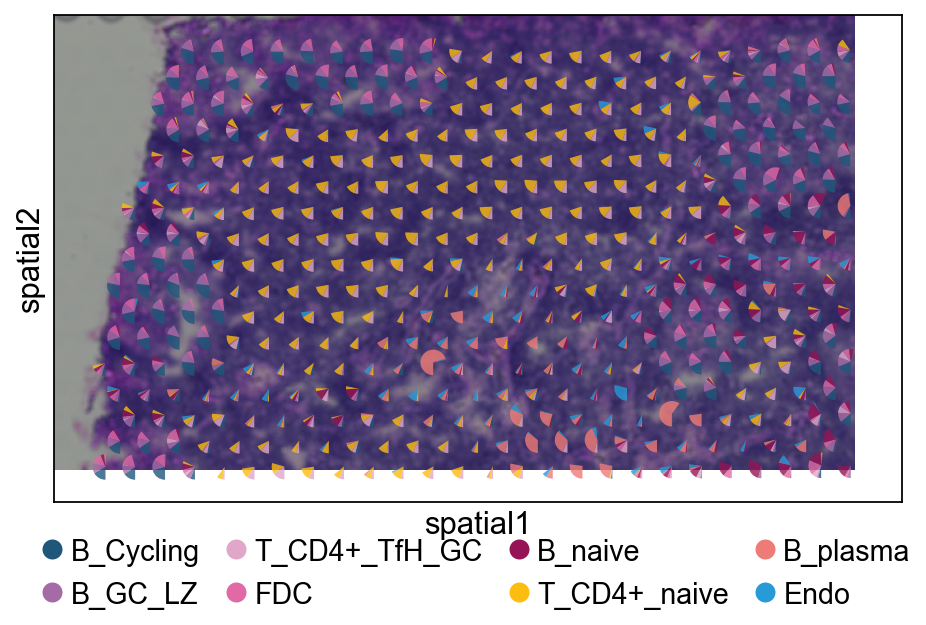

In [18]:
fig, ax = ov.plt.subplots(figsize=(8, 4))
sc.pl.spatial(
    adata_s, 
    basis='spatial',
    color=None,  
    size=1.3,
    img_key='hires',
    ax=ax,      
    show=False
)

ov.pl.add_pie2spatial(
    adata_s,
    img_key='hires',
    cell_type_columns=annotation_list[:],
    ax=ax,
    colors=color_dict,
    pie_radius=10,
    remainder='gap',
    legend_loc=(0.5, -0.25),
    ncols=4,
    alpha=0.8
)

#plt.show()